In [309]:
import pandas as pd
import numpy as np
from os import path

import matplotlib.pyplot as plt

from scipy.signal import lfilter

from scipy.linalg import eigh
from scipy.linalg import block_diag
from numpy.linalg import inv

In [2]:
# User inputs.
vintage = '2016-06-29'; # vintage dataset to use for estimation
country = 'US';         # United States macroeconomic data
sample_start  = '2000-01-01'; # estimation sample

# Define functions: load_spec, load_data

In [3]:
def load_spec(filename):
    spec = pd.read_excel(filename, sheet_name='spec');

    # keep variables with Model == 1 and drop 'Model' column
    spec = spec.loc[spec.Model.eq(1)].drop('Model', axis=1)

    spec_sort = pd.DataFrame()
    for f in ['d', 'w', 'm', 'q', 'sa', 'a']:
        spec_sort = pd.concat([spec_sort, spec.loc[spec.Frequency.eq(f)]], axis = 0)

    UnitsTransformed_dict = {'lin':'Levels (No Transformation)', 'chg':'Change (Difference)',
                             'ch1':'Year over Year Change (Difference)', 'pch':'Percent Change',
                             'pc1':'Year over Year Percent Change', 'pca':'Percent Change (Annual Rate)',
                             'cch':'Continuously Compounded Rate of Change', 
                             'cca':'Continuously Compounded Annual Rate of Change', 'log':'Natural Log'}

    spec_sort['UnitsTransformed'] = spec_sort['Transformation']
    spec_sort['UnitsTransformed'] = spec_sort['UnitsTransformed'].replace(UnitsTransformed_dict)
    spec_sort = spec_sort.set_index('SeriesID')
    Blocks = spec_sort.filter(regex='^Block', axis=1)
    Blocks.columns = [i for j,i in Blocks.columns.str.split('-').tolist()]
    
    spec_sort = spec_sort[spec_sort.columns.drop(list(spec_sort.filter(regex='Block')))]
    spec_sort = pd.concat([spec_sort], axis=1, keys=['Spec'])
    Blocks = pd.concat([Blocks], axis=1, keys=['Blocks'])

    return pd.concat([spec_sort, Blocks], axis=1)

def load_data(datafile, Spec, sample_start):
    Z = pd.read_excel(datafile, sheet_name='data')
    Z = Z.set_index('Date')
    Z = Z.asfreq('MS')

    if Z.dropna(how='all', axis=0).shape[0] != Z.shape[0]:
        print('Data file has missing dates.')

        Z.index.names = ['Time']
    Z = Z.loc[:, Spec.index]

    T, N = Z.shape

    f2m = dict(zip(['m', 'q', 'sa', 'a'], [1, 3, 6, 12])) # 
    f2a = dict(zip(['m', 'q', 'sa', 'a'], [12, 4, 2, 1])) # 

    X = pd.DataFrame(np.nan, index=Z.index, columns=Z.columns)

    for var in Z.columns:
        formular = Spec.Spec.loc[var, 'Transformation']
        freq = Spec.Spec.loc[var, 'Frequency']
        if formular == 'lin':   # Levels (No Transformation)
            X.loc[:, var] = Z.loc[:, var]
        elif formular == 'chg': # Change (Difference)
            X.loc[:, var] = Z.loc[:, var].diff(f2m[freq])
        elif formular == 'ch1': # YoY Change (Difference)
            X.loc[:, var] = Z.loc[:, var].diff(12)
        elif formular == 'pch': # Percent Change
            X.loc[:, var] = Z.loc[:, var].pct_change(f2m[freq], fill_method=None) * 100
        elif formular == 'pc1': # YoY Percent Change
            X.loc[:, var] = Z.loc[:, var].pct_change(12, fill_method=None) * 100
        elif formular == 'pca': # Percent Change (annualised)
            X.loc[:, var] = ((Z.loc[:, var].pct_change(f2m[freq], fill_method=None) + 1)**f2a[freq] - 1) * 100
        elif formular == 'log': # Natural log
            X.loc[:, var] = np.log(Z.loc[:, var])
        else:
            print('Transformation formular not found.')        

    Z = Z.loc[sample_start:]
    X = X.loc[sample_start:]
    return X, Z

def nanLE(rem1, X):
    nanLead = rem1.cumsum() == list(range(1, rem1.shape[0] + 1))  # 위부터 연속하여 NaN인 행 식별
    nanEnd = ((rem1.sum() - rem1.cumsum() + rem1)                 # rem1.cumsum(reverse=True)
               == list(range(rem1.shape[0], 0, -1)))              # 아래부터 연속하여 NaN인 행 식별
    nanLE = nanLead | nanEnd                                      # 위 또는 아래부터 연속하여 NaN인 행 식별
    X = X.loc[~nanLE]
    indNaN = X.isnull()
    return X, indNaN

def filtering(X, k):
    Y = X.copy()
    for var in X.columns:
        x = X[var].copy()
        isnanx = x.isnull()
        t1 = isnanx[isnanx.eq(False)].index[0]
        t2 = isnanx[isnanx.eq(False)].index[-1]
        x[t1:t2] = x[t1:t2].interpolate('cubic')  # GDPC1 with method 2: 1.4759/1.4731, 1.4277/1.4151 (matlab/python)
        isnanx = x.isnull()
        x.loc[x.isnull()] = x.median(skipna=True)
        x_ext = np.append(np.append([x.values[0]]*k, x.values), [x.values[-1]]*k)
        x_ma = lfilter(np.ones(2*k+1)/(2*k+1), 1, x_ext)  # equivalent to filter() in MATLAB
        x_ma = x_ma[2*k:]
        x_repl = pd.Series(x_ma, index=x.index)
        x[isnanx] = x_repl[isnanx]                # very similar to matlab; 1.7855/1.7851, 1.8790/1.8795 (matlab/python)
        Y.loc[:, var] = x
    return Y

def remNaNs_spline(X, optNaN): # spline without NaNs
    indNaN = X.isnull()
    T, N = X.shape

    if optNaN.method==1:     # replace all the missing values
        for var in X.columns:
            x = X[var].copy()
            isnanx = x.isnull()
            x.loc[isnanx] = x.median(skipna=True)
            x_ext = np.append(np.append([x.values[0]]*optNaN.k, x.values), [x.values[-1]]*optNaN.k)
            x_ma = lfilter(np.ones(2*optNaN.k+1)/(2*optNaN.k+1), 1, x_ext)
            x_ma = x_ma[2*k:]
            x_repl = pd.Series(x_ma, index=x.index)
            x[isnanx] = x_repl[isnanx]
            X[var] = x
        
    elif optNaN.method==2:   # replace missing values after removing leading and closing zeros
        rem1 = indNaN.sum(axis=1) > .8 * N                            # 80% 이상 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        X = filtering(X, optNaN.k)
            
    elif optNaN.method==3: # only remove rows with leading and closing zeros
        rem1 = indNaN.sum(axis=1) == N                                # 모든 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        
    elif optNaN.method==4:  # remove rows with leading and closing zeros & replace missing values
        rem1 = indNaN.sum(axis=1) == N                                # 모든 변수의 값이 NaN인 행 식별(NaN행)
        X, indNaN = nanLE(rem1, X)
        X = filtering(X, optNaN.k)
        
    elif optNaN.method==5:  # replace missing values  
        indNaN = X.isnull()
        X = filtering(X, optNaN.k)
    
    return X, indNaN

# Load `Spec` and `Data`

In [4]:
Spec = load_spec('Spec_US_example.xls');
# Parse `Spec`
# SeriesID = Spec.SeriesID; SeriesName = Spec.SeriesName; Units = Spec.Units; UnitsTransformed = Spec.UnitsTransformed;

datafile = path.join('data', country, vintage + '.xls')
X, Z = load_data(datafile, Spec, sample_start)

<AxesSubplot:xlabel='Date'>

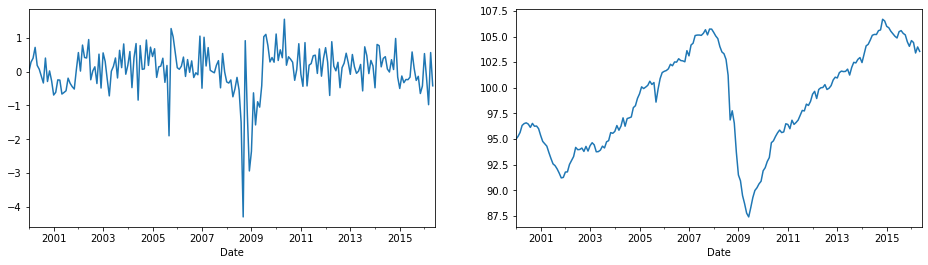

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4))

X.INDPRO.plot(ax=axs[0])
Z.INDPRO.plot(ax=axs[1])

# Estimation

## DFM input spec

In [6]:
T, N = X.shape;
blocks = Spec.Blocks;                    # Block loading structure
spec = Spec.Spec;                    # Block loading structure

nQ = sum(Spec.Spec.Frequency.eq('q'));   # Number of quarterly series
nM = N - nQ                              # number of monthly series
p = 1;                                   # Number of lags in autoregressive of factor
r = np.ones(blocks.shape[1], dtype=int);            # Number of common factors for each block
i_idio = np.array([True] * nM + [False] * nQ);

# R*Lambda = q; Contraints on the loadings of the quartrly variables
Rcon = np.array([[2, -1,  0,  0,  0],
                 [3,  0, -1,  0,  0],
                 [2,  0,  0, -1,  0],
                 [1,  0,  0,  0, -1]])
q = np.zeros(4);

threshold = 1e-5;  # EM loop threshold (default value)
max_iter = 5000;   # EM loop maximum number of iterations

## Prepare data

In [7]:
Mx = X.mean(skipna=True)
Wx = X.std(skipna=True)
xNaN = (X - Mx)/Wx        # Standardize series

### Initial Conditions

In [8]:
optNaN = pd.Series({'method':2, 'k':3})
# method=2 : Remove leading and closing zeros
# k=3      : Setting for filter(): See remNaN_spline

### [A, C, Q, R, Z_0, V_0] = InitCond(x, r, p, blocks, optNaN, Rcon, q, nQ, i_idio);

In [338]:
pC = Rcon.shape[1]    # 5, 'tent' structure size (quarterly to monthly)
ppC = max(p, pC)
n_b = blocks.shape[1]; # number of blocks

OPTS = pd.Series({'disp':0}) # turns off diagnostic information for eigenvalue computation
xBal, indNaN = remNaNs_spline(X, optNaN)

T, N = xBal.shape

xNaN = xBal.copy()
xNaN[indNaN] = np.nan   # set missing values equal to NaN

res = xBal.copy()
resNaN = xNaN.copy()

# Initialize model coefficient output
# C = np.empty((25, 0), int)
C = pd.DataFrame()
A = np.empty((0,0), int)
Q = np.empty((0,0), int)
V_0 = np.empty((0,0), int)

# Set the first observations as NaNs: For quarterly-monthly aggreg. scheme
indNaN.iloc[:pC-1, :] = True
    

In [339]:
    r_i = 1
    b = 'Global'
    C_i = pd.DataFrame(np.zeros((N, r_i*ppC)), index=spec.index)
    C_i.columns = pd.MultiIndex.from_product([range(ppC), range(1, r_i+1)]) # ppc lags, r_i factors
    idx_iM = blocks.loc[spec.Frequency.eq('m') & blocks[b].eq(1)].index
    idx_iQ = blocks.loc[spec.Frequency.eq('q') & blocks[b].eq(1)].index

    # Return eigenvectors v with largest r_i eigenvalues d
    d, v = eigh(res.loc[:, idx_iM].cov(), subset_by_index=[nM-r_i, nM-1])
    v = pd.DataFrame(v, index=idx_iM, columns=list(range(1, r_i+1)))

    # Flip sign for cleaner output. Gives equivalent results without this section
    v *= ((sum(v)>0)*2-1)

    # For monthly series with loaded blocks (rows), replace with eigenvector
    # This gives the loading
    C_i.loc[idx_iM, 0] = pd.concat([v], axis=1, keys=[0])
    f = res.loc[:, idx_iM].dot(v);  # Data projection for eigenvector direction
    F = pd.DataFrame(index=X.iloc[ppC-1:].index)
    
    for kk in range(max(p+1, pC)):
        f_lag = pd.concat([f.shift(kk)], axis=1, keys=[kk])
        F = pd.concat([F, f_lag], axis=1, join='inner')
        
    Rcon_i = np.kron(Rcon, np.eye(r_i))  # Quarterly-monthly aggregate scheme
    q_i = np.kron(q, np.zeros(r_i))      # Rcon_i * C_i = q_i

    # Produces projected data with lag structure (so pC-1 fewer entries)
    ff = F.iloc[:, :r_i*pC]
    
    for j in idx_iQ: # Loop for quarterly variables
        # For series j, values are dropped to accommodate lag structure
        xx_j = resNaN[j].iloc[pC-1:].copy()
        
        if (~xx_j.isnull()).sum().squeeze() < ff.shape[1] + 2:
            xx_j = res[j].iloc[pC-1:]              # Replaces xx_j with spline if too many NaNs

        ff_j = ff.loc[~xx_j.isnull(), :]

        xx_j = xx_j.loc[~xx_j.isnull()]
        iff_j = inv(ff_j.T.dot(ff_j))

        Cc = iff_j.dot(ff_j.T).dot(xx_j)    # least squares
        
        # Spline data monthly to quarterly conversion
        Cc = Cc - iff_j.dot(Rcon_i.T).dot(inv(Rcon_i.dot(iff_j).dot(Rcon_i.T))).dot(Rcon_i.dot(Cc))
        # Cc = Cc - iff_j.dot(Rcon_i.T).dot(inv(Rcon_i.dot(iff_j).dot(Rcon_i.T))).dot((Rcon_i.dot(Cc)-q_i))

        C_i.loc[j].iloc[:pC*r_i] = Cc

    # Zeros in first pC-1 entries (replace dropped from lag)
    ff = pd.concat([pd.DataFrame(0, index=res.iloc[:pC-1].index, columns=ff.columns), ff], axis=0)
    
    # Residual calculations
    res = res - ff.dot(C_i.T)
    resNaN = res.copy()
    resNaN[indNaN] = np.nan

In [340]:
    C = pd.concat([C, C_i], axis=1)

In [347]:
    F.columns = pd.MultiIndex.from_tuples(F.columns)

In [354]:
F

,0,1,2,3,4
,1,1,1,1,1
Date,,,,,
2000-05-01,168.909464,211.848700,342.141346,99.799056,172.899726
2000-06-01,-26.230056,168.909464,211.848700,342.141346,99.799056
2000-07-01,132.503507,-26.230056,168.909464,211.848700,342.141346
2000-08-01,0.370116,132.503507,-26.230056,168.909464,211.848700
2000-09-01,104.843186,0.370116,132.503507,-26.230056,168.909464
...,...,...,...,...,...
2016-01-01,344.385440,249.964229,46.756755,255.097644,141.929950
2016-02-01,168.946909,344.385440,249.964229,46.756755,255.097644


In [359]:
F.loc[:, 1:2]

,1,2
,1,1
Date,,
2000-05-01,211.848700,342.141346
2000-06-01,168.909464,211.848700
2000-07-01,-26.230056,168.909464
2000-08-01,132.503507,-26.230056
2000-09-01,0.370116,132.503507
...,...,...
2016-01-01,249.964229,46.756755
2016-02-01,344.385440,249.964229


In [ ]:
    ## Transition equation
    z = F.loc[:, 0]  # Projected data (no lag)
    Z = F.loc[:, 1:p]  # Data with lag 1
    
    
    A_i = np.zeros((r_i*ppC, r_i*ppC))  # Initialize transition matrix
    A_temp = np.linalg.inv(Z.T.dot(Z)).dot(Z.T).dot(z)   # OLS: gives coefficient value AR(p) process
    A_i[:r_i, :r_i*p] = A_temp.T
    A_i[r_i:, :r_i*(ppC-1)] = np.eye(r_i*(ppC-1))

In [1123]:
for r_i, b in zip(r, blocks.columns):    # loop for each block
    
    # Observation eq.
    C_i = pd.DataFrame(np.zeros((N, r_i*ppC)), index=spec.index)
    # lags = [0, 1, ..., ppC], factors = [1, 2, ..., r_i]
    C_i.columns = pd.MultiIndex.from_product([range(ppC), range(1, r_i+1)]) 
    idx_iM = blocks.loc[spec.Frequency.eq('m') & blocks[b].eq(1)].index
    idx_iQ = blocks.loc[spec.Frequency.eq('q') & blocks[b].eq(1)].index

    # Return eigenvectors v with largest r_i eigenvalues d
    d, v = eigh(res.loc[:, idx_iM].cov(), subset_by_index=[nM-r_i, nM-1])
    v = pd.DataFrame(v, index=idx_iM, columns=list(range(1, r_i+1)))

    # Flip sign for cleaner output. Gives equivalent results without this section
    v *= ((sum(v)>0)*2-1)

    # For monthly series with loaded blocks (rows), replace with eigenvector
    # This gives the loading
    C_i.loc[idx_iM, 0] = pd.concat([v], axis=1, keys=[0])
    f = res.loc[:, idx_iM].dot(v);  # Data projection for eigenvector direction
    F = pd.DataFrame(index=X.iloc[ppC-1:].index)

    # Lag matrix using loading. This is later used for quarterly series
    for kk in range(max(p+1, pC)):
        f_lag = pd.concat([f.shift(kk)], axis=1, keys=[kk])
        F = pd.concat([F, f_lag], axis=1, join='inner')

    Rcon_i = np.kron(Rcon, np.eye(r_i))  # Quarterly-monthly aggregate scheme
    q_i = np.kron(q, np.zeros(r_i))      # Rcon_i * C_i = q_i

    # Produces projected data with lag structure (so pC-1 fewer entries)
    ff = F.iloc[:, :r_i*pC]

    for j in idx_iQ: # Loop for quarterly variables
        # For series j, values are dropped to accommodate lag structure
        xx_j = resNaN[j].iloc[pC-1:].copy()
        
        if (~xx_j.isnull()).sum().squeeze() < ff.shape[1] + 2:
            xx_j = res[j].iloc[pC-1:]              # Replaces xx_j with spline if too many NaNs

        ff_j = ff.loc[~xx_j.isnull(), :]

        xx_j = xx_j.loc[~xx_j.isnull()]
        iff_j = inv(ff_j.T.dot(ff_j))

        Cc = iff_j.dot(ff_j.T).dot(xx_j)    # least squares
        
        # Spline data monthly to quarterly conversion
        Cc = Cc - iff_j.dot(Rcon_i.T).dot(inv(Rcon_i.dot(iff_j).dot(Rcon_i.T))).dot(Rcon_i.dot(Cc))
        # Cc = Cc - iff_j.dot(Rcon_i.T).dot(inv(Rcon_i.dot(iff_j).dot(Rcon_i.T))).dot((Rcon_i.dot(Cc)-q_i))

        C_i.loc[j].iloc[:pC*r_i] = Cc

    # Zeros in first pC-1 entries (replace dropped from lag)
    ff = pd.concat([pd.DataFrame(0, index=res.iloc[:pC-1].index, columns=ff.columns), ff], axis=0)

    # Residual calculations
    res = res.values - ff.dot(C_i.T)
    resNaN = res
    resNaN[indNaN] = np.nan

    C = np.append(C, C_i, axis=1)

    ## Transition equation
    z = F[:, :r_i]  # Projected data (no lag)
    Z = F[:, r_i:r_i*(p+1)]  # Data with lag 1
    A_i = np.zeros((r_i*ppC, r_i*ppC))  # Initialize transition matrix
    A_temp = np.linalg.inv(Z.T.dot(Z)).dot(Z.T).dot(z)   # OLS: gives coefficient value AR(p) process
    A_i[:r_i, :r_i*p] = A_temp.T
    A_i[r_i:, :r_i*(ppC-1)] = np.eye(r_i*(ppC-1))

    Q_i = np.zeros((ppC*r_i, ppC*r_i))
    e = z - Z.dot(A_temp)       # VAR residuals
    Q_i[:r_i, :r_i] = np.cov(e, rowvar=False) # VAR covariance matrix

    initV_i = np.linalg.inv(np.eye((r_i*ppC)**2)-np.kron(A_i, A_i)).dot(Q_i.flatten('F')).reshape(r_i*ppC, r_i*ppC, order='F')

    # Gives top left block for the transition matrix
    A = block_diag(A, A_i)
    Q = block_diag(Q, Q_i)
    V_0 = block_diag(V_0, initV_i)

In [1126]:
eyeN = np.eye(N)  # Used inside observation matrix

In [1127]:
eyeN = eyeN[:, i_idio]

In [1128]:
C = np.append(C, eyeN, axis=1)

In [1129]:
# Monthly-quarterly aggregate scheme
C = np.append(C, np.append(np.zeros((nM, 5*nQ)), np.kron(np.eye(nQ), [1, 2, 3, 2, 1]), axis=0), axis=1)

In [1139]:
R = np.diag(np.var(resNaN))

In [1143]:
# ii_idio = find(i_idio);    # Indicies for monthly variables
n_idio = nM;  # Number of monthly variables
BM = np.zeros((n_idio, n_idio));        # Initialize monthly transition matrix values
SM = np.zeros((n_idio, n_idio));        # Initialize monthly residual covariance matrix values

In [1144]:
BM

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0.,